# Importing libraries and scripts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
import random

warnings.filterwarnings('ignore')
sys.path.append('..')

from scripts import dataframe as dfr
from scripts import matrix as mx
from scripts import regression as rgr
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score

from collections import Counter

# Reading the data and training the model

In [2]:
df = pd.read_csv('../week_3/churn_data.csv')

df = dfr.data_frame_refining(df)

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

numerical_cols = ['tenure', 'monthlycharges', 'totalcharges']
categorical_cols = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [3]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_cols + numerical_cols].to_dict(orient='records')
val_dict = df_val[categorical_cols + numerical_cols].to_dict(orient='records')

In [4]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [5]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [6]:
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = y_pred >= 0.5

(y_val == churn_decision).mean()

0.8034066713981547

# Accuracy and dummy model

In [7]:
(y_val == churn_decision).sum()

1132

In [8]:
thresholds = np.linspace(0,1,21)

scores = []

for threshold in thresholds:
    churn_decision = y_pred >= threshold

    # score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val,churn_decision)

    print('%.2f %.3f' %(threshold,score))

    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


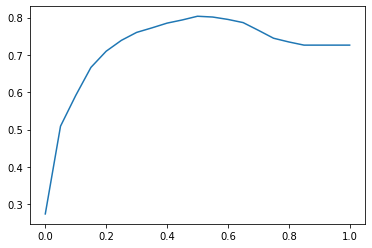

In [9]:
plt.plot(thresholds,scores)

# Confusion matrix

In [10]:
actual_positive = y_val == 1
actual_negative = y_val == 0

predict_positive = y_pred >= 0.5
predict_negative = y_pred < 0.5

In [11]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

In [12]:
tn , tp

(922, 210)

In [13]:
fn = (predict_negative & actual_positive).sum()
fp = (predict_positive & actual_negative).sum()

In [14]:
fn, fp

(176, 101)

In [15]:
confusion_mx = np.array([
    [tn,fp],
    [fn,tp]
])

confusion_mx

array([[922, 101],
       [176, 210]])

In [16]:
churn_decision = y_pred >= 0.5
confusion_matrix(y_val,churn_decision)

array([[922, 101],
       [176, 210]])

# Precision and Recall

In [17]:
accuracy = ( tn + tp ) / ( tn + tp + fp + fn )
accuracy

0.8034066713981547

In [18]:
precision = tp / (tp + fp )
precision.round(3)

0.675

In [19]:
recall = tp / ( tp + fn )
recall.round(3)

0.544

# ROC (Recievers Operating Characterstics)

In [20]:
fpr = fp / (tn + fp)
fpr

0.09872922776148582

In [21]:
tpr = tp / (fn + tp)
tpr

0.5440414507772021

In [22]:
df_scores = dfr.tpr_fpr_dfr(y_val,y_pred)

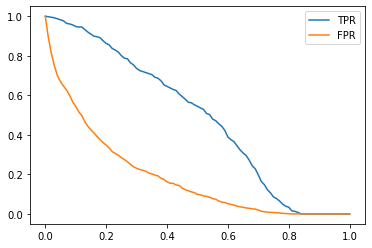

In [23]:
dfr.plot_tpr_fpr_graph(df_scores)

## Random Model

In [24]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [25]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [26]:
df_random = dfr.tpr_fpr_dfr(y_val,y_rand)
df_random[::20]

,threshold,tp,tn,fn,fp,fpr,tpr
0,0.0,386,0,0,1023,1.000000,1.000000
20,0.2,307,201,79,822,0.803519,0.795337
40,0.4,237,399,149,624,0.609971,0.613990
60,0.6,161,614,225,409,0.399804,0.417098
80,0.8,78,817,308,206,0.201369,0.202073
100,1.0,0,1023,386,0,0.000000,0.000000


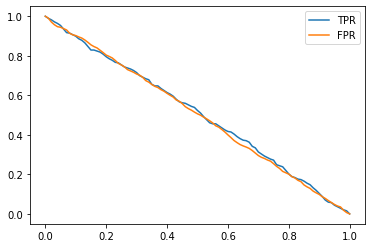

In [27]:
dfr.plot_tpr_fpr_graph(df_random)

## Ideal Model

In [28]:
num_pos = (y_val == 1).sum()
num_neg = (y_val == 0).sum()
num_pos , num_neg

(386, 1023)

In [29]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])

In [30]:
mean_value = 1 - y_ideal.mean()

In [31]:
y_ideal_pred = np.linspace(0,1,len(y_ideal))

In [32]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [33]:
df_ideal = dfr.tpr_fpr_dfr(y_ideal,y_ideal_pred)

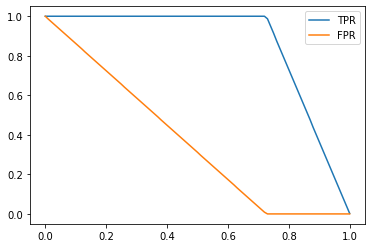

In [34]:
dfr.plot_tpr_fpr_graph(df_ideal)

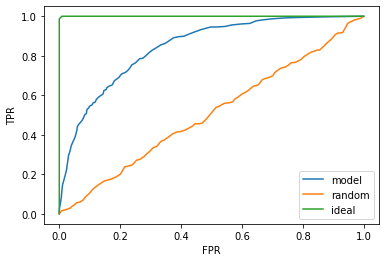

In [35]:
dfr.plot_three_tpr_fpr(df_scores,df_random,df_ideal,'model','random','ideal')

In [36]:
fpr,tpr,threshold = roc_curve(y_val,y_pred)

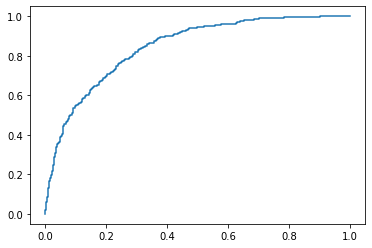

In [37]:
plt.plot(fpr,tpr,label = 'Model')

# AUC ( Area Under the Curve )

In [38]:
auc(fpr,tpr)

0.8438530381535563

In [39]:
auc(df_scores.fpr,df_scores.tpr)

0.8438732975754537

In [40]:
roc_auc_score(y_val,y_pred)

0.8438530381535563

In [41]:
pos = y_pred[y_val == 1]
neg = y_pred[y_val == 0]

In [42]:
n = 100000
success = 0

for i in range(n):

    pos_ind = random.randint(0,len(pos)-1)
    neg_ind = random.randint(0,len(neg)-1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84507

# K-Fold Cross validation

In [46]:
dv,model = dfr.train(df_train,y_train,categorical_cols,numerical_cols)
y_pred = dfr.predict(df_train,categorical_cols,numerical_cols,dv,model)
y_pred

array([0.09548805, 0.67933076, 0.63367906, ..., 0.53163019, 0.04254039,
       0.69873064])

In [47]:
kfold = KFold(n_splits=5,shuffle=True,random_state = 1)

In [48]:
train_idx , val_idx = next(kfold.split(df_full_train))

In [49]:
len(train_idx) , len(val_idx)

(4507, 1127)

In [50]:
len(df_full_train)

5634

In [52]:
n_splits = 5

for C in tqdm([0.01,0.1,0.001,1,5,10]):

    scores = []

    for train_idx , val_idx in kfold.split(df_full_train):

        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv , model = dfr.train(df_train,y_train,categorical_cols,numerical_cols,C)
        y_pred = dfr.predict(df_val,categorical_cols,numerical_cols,dv,model)

        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)

    print('Average score of %.3f and Standard deviation of %.3f with Regularization strength of %.3f' % (np.mean(scores) , np.std(scores),C))

 17%|█▋        | 1/6 [00:03<00:15,  3.08s/it]

Average score of 0.840 and Standard deviation of 0.009 with Regularization strength of 0.010


 33%|███▎      | 2/6 [00:06<00:12,  3.03s/it]

Average score of 0.841 and Standard deviation of 0.008 with Regularization strength of 0.100


 50%|█████     | 3/6 [00:08<00:08,  2.91s/it]

Average score of 0.825 and Standard deviation of 0.009 with Regularization strength of 0.001


 67%|██████▋   | 4/6 [00:11<00:05,  2.90s/it]

Average score of 0.840 and Standard deviation of 0.008 with Regularization strength of 1.000


 83%|████████▎ | 5/6 [00:15<00:03,  3.06s/it]

Average score of 0.841 and Standard deviation of 0.008 with Regularization strength of 5.000


100%|██████████| 6/6 [00:19<00:00,  3.18s/it]

Average score of 0.841 and Standard deviation of 0.008 with Regularization strength of 10.000


In [54]:
dv,model = dfr.train(df_full_train,df_full_train.churn.values,categorical_cols,numerical_cols,1)
y_pred_final = dfr.predict(df_test,categorical_cols,numerical_cols,dv,model)
auc = roc_auc_score(y_test,y_pred_final)
auc

0.8572386167896259